In [9]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

params = {
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [2]:
def plot_bar(df, flip_colors=False):
    cmap= plt.get_cmap('autumn')
    
    c = (df - df.min()) / (df.max() - df.min())
    c = 1-c if flip_colors else c
    
    df.plot(kind='bar', color=cmap(c))
    ax = plt.gca()
    labels = ax.get_xticklabels()
    ax.set_xticklabels([l.get_text().split(',')[0][1:] for l in labels])
    ax.set_xlabel('No. GPUs')
    

In [3]:
file_names = list(Path('pearl2').glob('**/*.json'))
gpus = [int(str(name).rsplit('_')[1].split('/')[0]) for name in file_names]
df = pd.concat([pd.read_json(file_name) for file_name in file_names], keys=gpus)
df

train         test
1 warmup_avg_ips       1.150270     1.027157
  warmup_duration  10277.538768    24.819796
  avg_ips              9.935705     1.157525
  total_duration   44016.056259  2507.705477
  full_avg_ips         9.642857     1.156441
  loss                      NaN     0.674966
  accuracy                  NaN     0.795887
2 warmup_avg_ips       1.203708     1.053228
  warmup_duration  10116.482130    47.007263
  avg_ips             19.205296     1.169623
  total_duration   27610.009316  2501.453798
  full_avg_ips        18.605243     1.167694
  loss                      NaN     0.670040
  accuracy                  NaN     0.787161
4 warmup_avg_ips       1.302911     1.022659
  warmup_duration  10507.737841    95.149808
  avg_ips             35.754087     1.175905
  total_duration   19924.787536  2593.585436
  full_avg_ips        34.605715     1.170853
  loss                      NaN     0.520281
  accuracy                  NaN     0.838500

## Training Warmup

In [4]:
warmup_avg = df.loc[df.index.get_level_values(1) == 'warmup_avg_ips']
warmup_total = df.loc[df.index.get_level_values(1) == 'warmup_duration']

Text(0.5, 1.0, 'Images/s in Training Warmup Phase on PEARL ($1^{st}$ Epoch)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


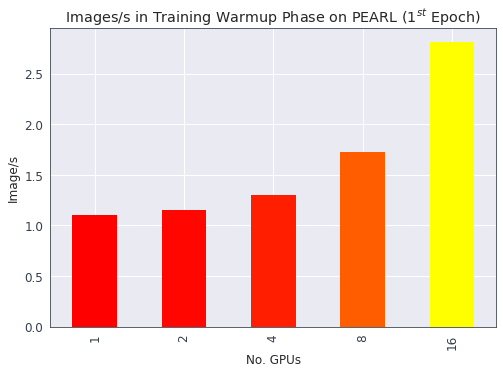

In [197]:
plot_bar(warmup_avg.train)
plt.ylabel('Image/s')
plt.title('Images/s in Training Warmup Phase on PEARL ($1^{st}$ Epoch)')

Text(0.5, 1.0, 'Total Duration of Training Warmup Phase on PEARL ($1^{st}$ Epoch)')

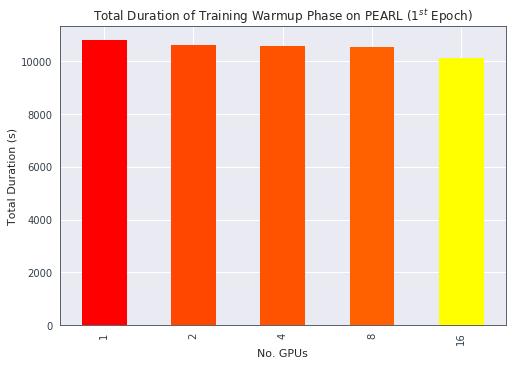

In [176]:
plot_bar(warmup_total.train, flip_colors=True)
plt.ylabel('Total Duration (s)')
plt.title('Total Duration of Training Warmup Phase on PEARL ($1^{st}$ Epoch)')

## Training/Test

In [6]:
avg = df.loc[df.index.get_level_values(1) == 'avg_ips']
total = df.loc[df.index.get_level_values(1) == 'total_duration']

### Images/s Analysis

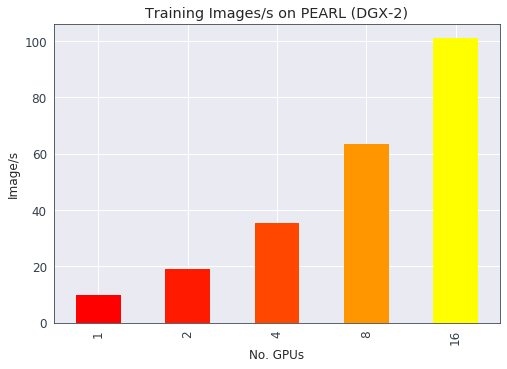

In [198]:
plot_bar(avg.train, flip_colors=False)
plt.ylabel('Image/s')
plt.title('Training Images/s on PEARL (DGX-2)')
plt.savefig('images/training_images_per_sec.png', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Image/s')

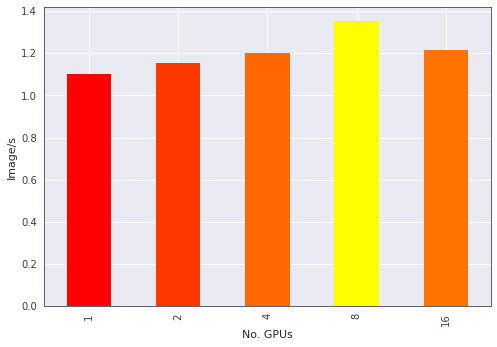

In [182]:
plot_bar(avg.test, flip_colors=False)
plt.ylabel('Image/s')

### Total Duration & Speedup

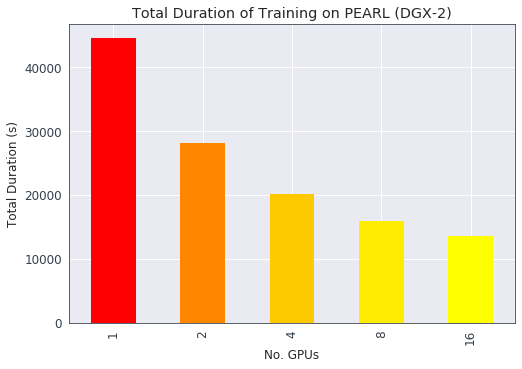

In [199]:
plot_bar(total.train, flip_colors=True)
plt.ylabel('Total Duration (s)')
plt.title('Total Duration of Training on PEARL (DGX-2)')
plt.savefig('images/training_duration.png', bbox_inches='tight', dpi=300)

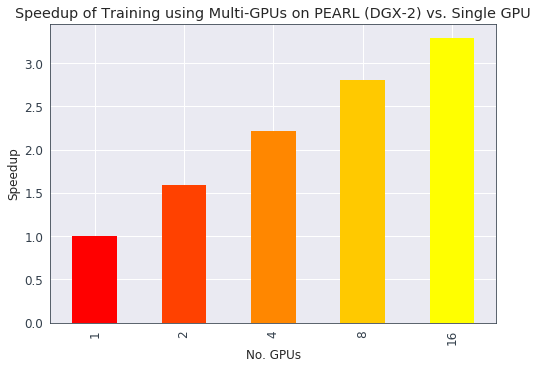

In [200]:
plot_bar(total.train.iloc[0] / total.train)
plt.ylabel('Speedup')
plt.title('Speedup of Training using Multi-GPUs on PEARL (DGX-2) vs. Single GPU')
plt.savefig('images/training_speedup.png', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Total Duration (s)')

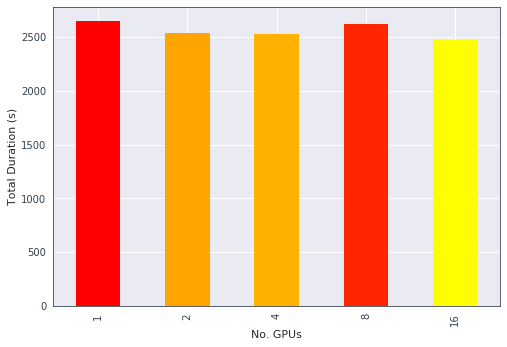

In [187]:
plot_bar(total.test, flip_colors=True)
plt.ylabel('Total Duration (s)')

## Duration without Warmup

Text(0, 0.5, 'Total Duration (s)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


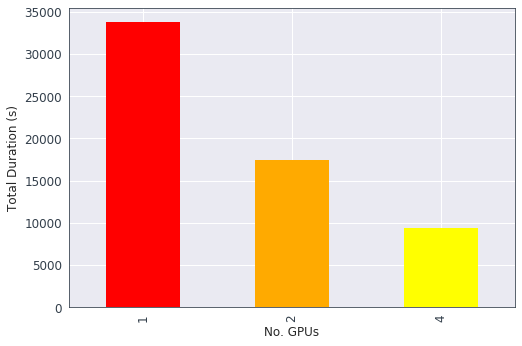

In [7]:
post_warmup_duration = pd.Series(total.train.values - warmup_total.train.values, index=total.train.index)
plot_bar(post_warmup_duration, flip_colors=True)
plt.ylabel('Total Duration (s)')

Text(0.5, 1.0, 'No. GPUs vs. Speedup for Training Inc./Exc. Data Loading')

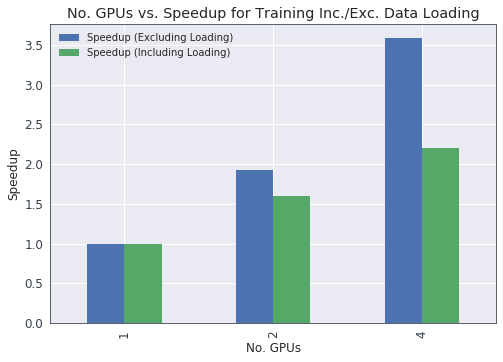

In [10]:
compare_df = total.copy()
compare_df['post_warmup_speed'] = post_warmup_duration.iloc[0] / post_warmup_duration
compare_df['speed'] = total.train.iloc[0] / total.train

compare_df[['post_warmup_speed', 'speed']].plot(kind='bar')
ax = plt.gca()
# compare_df[['post_warmup_speed', 'speed']].plot(ax=ax, style='--', cmap='Set1', marker='o')
labels = ax.get_xticklabels()
ax.set_xticklabels([l.get_text().split(',')[0][1:] for l in labels])
ax.set_xlabel('No. GPUs')
plt.legend(['Speedup (Excluding Loading)', 'Speedup (Including Loading)'])

plt.ylabel('Speedup')
plt.title('No. GPUs vs. Speedup for Training Inc./Exc. Data Loading')
# plt.savefig('images/speedup_comparison.png', bbox_inches='tight', dpi=300)